In [2]:
import pandas as pd
from boruta import BorutaPy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


In [3]:
#read data
X=pd.read_csv('.\\alternative_data_set\\X_diesel.csv',header=None)
Y=pd.read_csv('.\\alternative_data_set\\Y3_diesel.csv',header=None)

In [4]:
#remove missing values
X=X.copy()
X['target_variable']=Y[1]
X=X.dropna()
X=X.reset_index(drop=True)
Y=X.iloc[:,401]
X=X.iloc[:,:401]

In [8]:
#data split and normalisation
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.6,random_state=42)
x_dev,x_test,y_dev,y_test=train_test_split(x_test,y_test,test_size=0.5,random_state=42)

#train 0.6
#dev 0.2
#test 0.2
#norm
scaler_x = StandardScaler()
scaler_x.fit(x_train)
x_train=scaler_x.transform(x_train)
x_dev=scaler_x.transform(x_dev)
x_test=scaler_x.transform(x_test)

scaler_y=StandardScaler()
scaler_y.fit(y_train.values.reshape(-1,1))
y_train=scaler_y.transform(y_train.values.reshape(-1,1))
y_dev=scaler_y.transform(y_dev.values.reshape(-1,1))
y_test=scaler_y.transform(y_test.values.reshape(-1,1))


### Tests

In [5]:
#fitting model

model_nn = MLPRegressor(hidden_layer_sizes=(2),
                        max_iter=10000,
                        random_state=42,)

#fit
model_nn.fit(x_train,y_train.ravel())

#get predictions
test_pred=model_nn.predict(x_test)
dev_pred=model_nn.predict(x_dev)
train_pred=model_nn.predict(x_train)

test_mse = mean_squared_error(y_test, test_pred)
dev_mse=mean_squared_error(y_dev,dev_pred)
train_mse=mean_squared_error(y_train,train_pred)

print('train mse: ' +str(train_mse)+'\n'+'dev mse: ' +str(dev_mse)+'\n'+'test mse: '+str(test_mse))


train mse: 0.25395925573409456
dev mse: 0.35007942702723743
test mse: 0.41107304982878795


Text(0.5, 1.0, "Before 'boruta'")

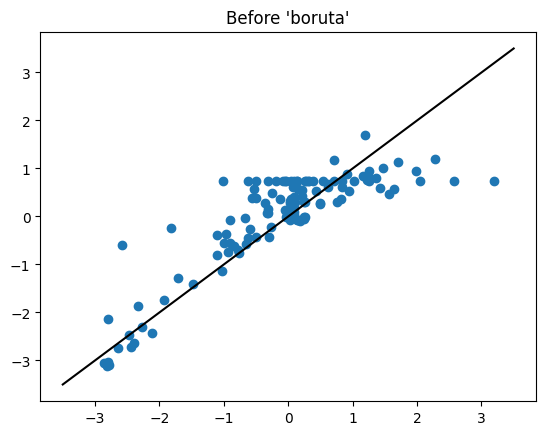

In [6]:
#parity on test set
plt.scatter(y_test, test_pred)
plt.plot([-3.5,3.5],[-3.5,3.5],'black')
plt.title('Before \'boruta\'')

### Importance evaluation

In [7]:
layers=[(2,),(2,2),(2,2,2),(4,),(4,4),(4,4,4)]
importance_df=pd.DataFrame()
index_of_imp={}

for structure in layers:
    
    # Train MLPRegressor
    mlp = MLPRegressor(hidden_layer_sizes=structure,
                        max_iter=10000,
                        random_state=42,)

    mlp.fit(x_train, y_train.ravel())

    # Perform permutation importance
    results = permutation_importance(mlp, x_dev, y_dev, n_repeats=10, random_state=42, n_jobs=-1)

    
    # Get the importance of the features
    importance = results.importances_mean
    
    importance_df['layers'+str(structure)]=importance

In [8]:
layers=[(2,),(2,2),(2,2,2),(4,),(4,4),(4,4,4)]
importance_df=pd.DataFrame()
index_of_imp={}

for structure in layers:
    
    # Train MLPRegressor
    mlp = MLPRegressor(hidden_layer_sizes=structure,
                        max_iter=10000,
                        random_state=42,)

    mlp.fit(x_train, y_train.ravel())

    # Perform permutation importance
    results = permutation_importance(mlp, x_dev, y_dev, n_repeats=10, random_state=42, n_jobs=-1)
    
    # Get the importance of the features
    importance = results.importances_mean

    #replace negative values by zero
    importance[importance<0]=0
    
    #norm
    scaler=MinMaxScaler()
    importance=scaler.fit_transform(importance.reshape(-1,1)).flatten()
    
    importance_df['layers'+str(structure)]=importance

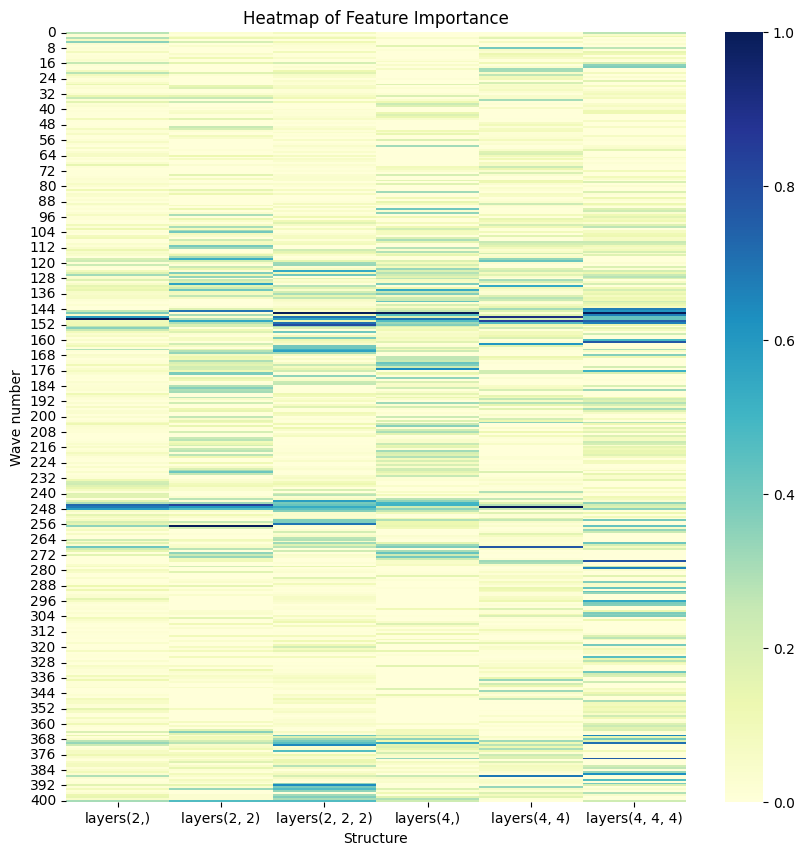

In [9]:
#heatmap to evaluate how consistent are these
#''bands'' are somewhat consistent
plt.figure(figsize=(10, 10))
sns.heatmap(importance_df, annot=False, cmap="YlGnBu", fmt=".2f")
plt.title('Heatmap of Feature Importance')
plt.xlabel('Structure')
plt.ylabel('Wave number')
plt.show()


### benchmarking

In [10]:
#get some values for different training
layers=[(2,),(2,2),(2,2,2),(4,),(4,4),(4,4,4)]

stored = pd.DataFrame()

x_train=pd.DataFrame(x_train)
x_test=pd.DataFrame(x_test)

for structure in layers:
    
    for i in np.arange(0,0.15,0.001):

        #get indexing of only features with importance over i over layer 'structure'
        importance=importance_df.T.loc['layers'+str(structure),:]
        mask=importance>=i
        
        #slice of important features
        columns_to_keep=mask[mask].index
        x_train_important=x_train[columns_to_keep]
        x_test_important=x_test[columns_to_keep]
        
        #get predictions
        model_nn=MLPRegressor(hidden_layer_sizes=structure,
                            max_iter=10000,
                            random_state=42,)

        #fit pred and mean squared error
        model_nn.fit(x_train_important,y_train.ravel())
        test_pred_important=model_nn.predict(x_test_important)
        test_mse_i = mean_squared_error(y_test, test_pred_important)
        #store
        stored.loc[i,'layers'+str(structure)] = test_mse_i

In [23]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(stored)

       layers(2,)  layers(2, 2)  layers(2, 2, 2)  layers(4,)  layers(4, 4)  \
0.000       0.411         0.330            0.106       0.209         0.222   
0.001       0.328         0.569            0.594       0.307         0.568   
0.002       0.160         0.137            0.280       0.176         0.132   
0.003       0.199         0.253            0.360       0.156         0.139   
0.004       0.560         0.330            0.342       0.131         0.149   
0.005       2.264         0.343            0.250       0.107         0.153   
0.006       0.297         0.190            1.566       0.158         0.140   
0.007       0.254         0.253            0.658       0.158         1.027   
0.008       0.159         0.330            1.505       0.175         0.163   
0.009       0.234         0.246            0.309       0.153         0.316   
0.010       0.169         0.302            1.466       0.153         0.293   
0.011       0.137         0.331            0.433       0.101    

In [12]:
#get some values for different training
columns=['threshold','train mse','dev mse','test mse','wavelengths included']
stored_2 = pd.DataFrame(columns=columns)


for i in np.arange(0,0.4,0.01):

    #get indexing of only features with importance over i over layer 'structure'
    importance=importance_df.T.loc['layers'+str((2,)),:]
    mask=importance>=i
        
    #slice of important features
    columns_to_keep=mask[mask].index
    x_train_important=x_train[columns_to_keep]
    x_dev_important=pd.DataFrame(x_dev)[columns_to_keep]
    x_test_important=x_test[columns_to_keep]
    
    #get predictions
    model_nn=MLPRegressor(hidden_layer_sizes=(2,),
                            max_iter=10000,
                            random_state=42,)

    #fit pred and mean squared error
    model_nn.fit(x_train_important,y_train.ravel())
    
    train_pred_important=model_nn.predict(x_train_important)
    dev_pred_important=model_nn.predict(x_dev_important)
    test_pred_important=model_nn.predict(x_test_important)
    
    train_mse_i=mean_squared_error(y_train,train_pred_important)
    dev_mse_i=mean_squared_error(y_dev,dev_pred_important)
    test_mse_i = mean_squared_error(y_test, test_pred_important)
    
    num_features=x_train_important.shape[1]
    #store
    stored_2.loc[i] = [i,train_mse_i,dev_mse_i,test_mse_i,num_features]

In [13]:
stored_2

,threshold,train mse,dev mse,test mse,wavelengths included
0.00,0.00,0.253959,0.350079,0.411073,401.0
0.01,0.01,0.085776,0.181413,0.169273,287.0
0.02,0.02,0.075453,0.285623,0.183191,226.0
0.03,0.03,0.111217,0.230468,0.287455,192.0
0.04,0.04,0.178310,0.494788,0.325746,162.0
0.05,0.05,0.081412,0.214926,0.140993,143.0
0.06,0.06,0.190916,0.491499,0.336379,129.0
0.07,0.07,0.243430,0.386756,0.414987,110.0
0.08,0.08,0.265567,0.499063,0.527119,98.0
0.09,0.09,0.142500,0.315252,0.314138,88.0


### same tests but with cross validation

In [5]:
layers = [(2,), (2,2), (2,2,2), (4,), (4,4,4)] #removed (4,4) for testing
#layers = [(4,4), (4,4,4),(2,2,2,2),(4,4,4,4),(8,8,8)]
importance_df_cross = pd.DataFrame()

kf=KFold(n_splits=5,shuffle=True,random_state=42)

for structure in layers:
    
    fold_importance=np.zeros((X.shape[1],kf.n_splits))
    
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        
        x_train_fold,x_val_fold=X.iloc[train_index],X.iloc[test_index]
        y_train_fold,y_val_fold=Y[train_index],Y[test_index]
        
        #modelo
        model_nn=MLPRegressor(hidden_layer_sizes=structure,
                            max_iter=10000,
                            random_state=42,)
        
        model_nn.fit(x_train_fold,y_train_fold)
        #permutation importance
        results=permutation_importance(model_nn,x_val_fold,y_val_fold,n_repeats=10,random_state=42, n_jobs=4)
        
        fold_importance[:,fold]=results.importances_mean
        
    #get average among kfolds
    mean_importance=fold_importance.mean(axis=1)
    
    #zero out neg values
    mean_importance[mean_importance<0]=0
    
    #norm
    scaler=MinMaxScaler()
    norm_importance=scaler.fit_transform(mean_importance.reshape(-1,1)).flatten()
    
    #store to frame
    importance_df_cross['layers'+str(structure)]=norm_importance
    

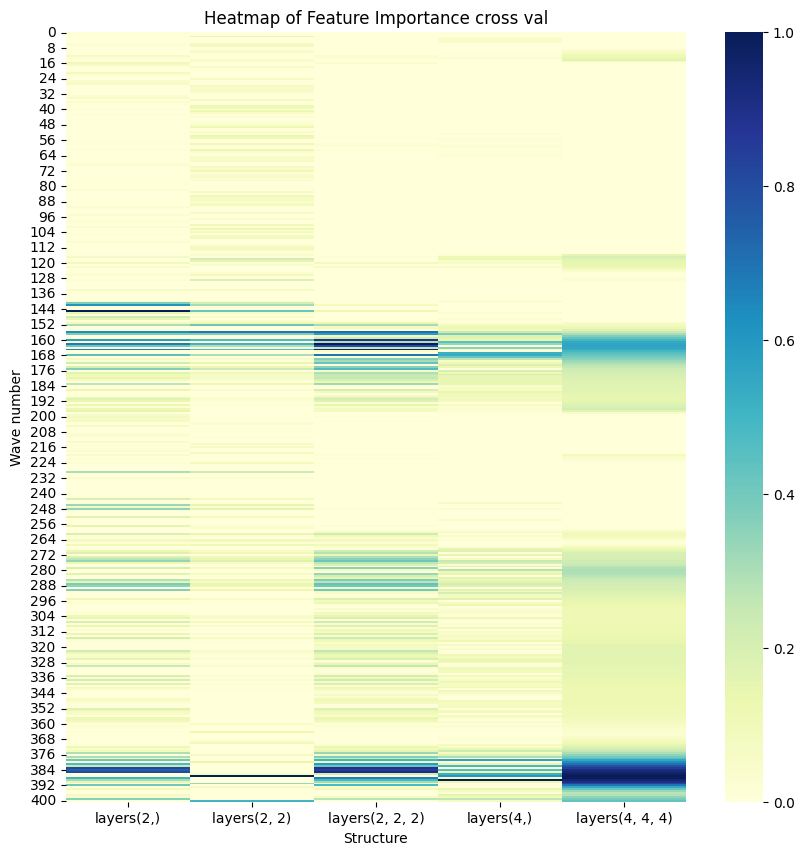

In [6]:
#heatmap to evaluate how consistent are these
#''bands'' are somewhat consistent
plt.figure(figsize=(10, 10))
sns.heatmap(importance_df_cross, annot=False, cmap="YlGnBu", fmt=".2f")
plt.title('Heatmap of Feature Importance cross val')
plt.xlabel('Structure')
plt.ylabel('Wave number')
plt.show()

In [63]:
#cross to evaluate importance and cross validation with important features
#this manner sort of dilutes the results and i can't find the better model...
layers=[(2,),(2,2),(2,2,2),(4,),(4,4,4)]

stored_cross = pd.DataFrame()

kf=KFold(n_splits=5,shuffle=True,random_state=42)



for structure in layers:
    
    for i in np.arange(0,0.9,0.15):
        
        fold_scores=np.empty(5)
    
        for fold, (train_index,test_index) in enumerate(kf.split(X)):
            
            x_train_fold,x_val_fold=X.iloc[train_index],X.iloc[test_index]
            y_train_fold,y_val_fold=Y[train_index],Y[test_index]

            #get indexing of only features with importance over i over layer 'structure'
            importance=importance_df_cross.T.loc['layers'+str(structure),:]
            mask=importance>=i
            
            #slice of important features
            columns_to_keep=mask[mask].index
            x_train_important=x_train_fold[columns_to_keep]
            x_val_important=x_val_fold[columns_to_keep]
            
            #get predictions
            model_nn=MLPRegressor(hidden_layer_sizes=structure,
                                max_iter=10000,
                                random_state=42,)

            #fit pred and mean squared error
            
            model_nn.fit(x_train_important,y_train_fold.ravel())
            
            val_pred_important=model_nn.predict(x_val_important)
            
            test_mse_i = mean_squared_error(y_val_fold, val_pred_important)
            
            fold_scores[fold]=test_mse_i
            
            
        #store
        stored_cross.loc[i,'layers'+str(structure)] = fold_scores.mean()

In [64]:
stored_cross

,"layers(2,)","layers(2, 2)","layers(2, 2, 2)","layers(4,)","layers(4, 4, 4)"
0.00,0.276763,0.298697,0.283522,0.272366,0.276196
0.15,0.276502,0.272190,0.285156,0.311267,0.279125
0.30,0.314278,0.286483,0.312424,0.312511,0.280158
0.45,0.313264,0.311656,0.280795,0.262838,0.279005
0.60,0.309310,0.287871,0.284530,0.280543,0.297402
0.75,0.291962,0.279735,0.309318,0.276776,0.306314


In [19]:

importance_df=importance_df_cross


#get some values for different training
layers=[(2,),(2,2),(2,2,2),(4,),(4,4,4)]

stored = pd.DataFrame()

x_train=pd.DataFrame(x_train)
x_test=pd.DataFrame(x_test)

for structure in layers:
    
    for i in np.arange(0,0.2,0.002):

        #get indexing of only features with importance over i over layer 'structure'
        importance=importance_df.T.loc['layers'+str(structure),:]
        mask=importance>=i
        
        #slice of important features
        columns_to_keep=mask[mask].index
        x_train_important=x_train[columns_to_keep]
        x_test_important=x_test[columns_to_keep]
        
        #get predictions
        model_nn=MLPRegressor(hidden_layer_sizes=structure,
                            max_iter=10000,
                            random_state=42,)

        #fit pred and mean squared error
        model_nn.fit(x_train_important,y_train.ravel())
        test_pred_important=model_nn.predict(x_test_important)
        test_mse_i = mean_squared_error(y_test, test_pred_important)
        #store
        stored.loc[i,'layers'+str(structure)] = test_mse_i

In [21]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(stored)

       layers(2,)  layers(2, 2)  layers(2, 2, 2)  layers(4,)  layers(4, 4, 4)
0.000       0.411         0.330            0.106       0.209            0.463
0.002       0.198         0.129            0.651       0.170            0.267
0.004       0.205         0.478            0.347       0.161            0.308
0.006       0.286         0.471            1.608       0.267            0.672
0.008       0.187         0.347            0.928       0.173            0.672
0.010       0.216         1.541            0.491       0.229            0.264
0.012       0.290         1.464            0.162       0.175            0.264
0.014       0.392         0.350            1.536       0.279            0.280
0.016       0.383         1.512            0.785       0.185            0.242
0.018       0.228         0.585            1.459       0.159            0.242
0.020       0.271         0.246            1.463       0.203            0.242
0.022       0.217         0.451            1.472       0.230    